In [3]:
!pip install tensorflow-gpu==2.8.0

     |████████████████████████████████| 497.5 MB 20 kB/s 
     |████████████████████████████████| 5.8 MB 48.7 MB/s 
     |████████████████████████████████| 462 kB 57.0 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Attempting uninstall: tensorflow-gpu
    Found existing installation: tensorflow-gpu 2.1.0
    Uninstalling tensorflow-gpu-2.1.0:
      Successfully uninstalled tensorflow-gpu-2.1.0


In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [2]:
def feature_extractor(inputs):
  feature_extractor_layer = tf.keras.applications.resnet.ResNet50(
      input_shape=(224, 224, 3),
      include_top = False,
      weights="imagenet")(inputs) 

  return feature_extractor_layer

In [3]:
def classifier(inputs):
  x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation="relu")(x)
  x = tf.keras.layers.Dense(512, activation="relu")(x) 
  x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x) 
  return x

In [4]:
def final_model(inputs):
  resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
  resnet_feature_extractor = feature_extractor(resize)

  classification = classifier(resnet_feature_extractor)
  return classification

In [5]:
#Defining Batch Size 
BATCH_SIZE = 32 

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
#title Visualization Utilities[RUN ME]
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [7]:
(training_images, training_labels), (validation_images, validation_labels)=tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


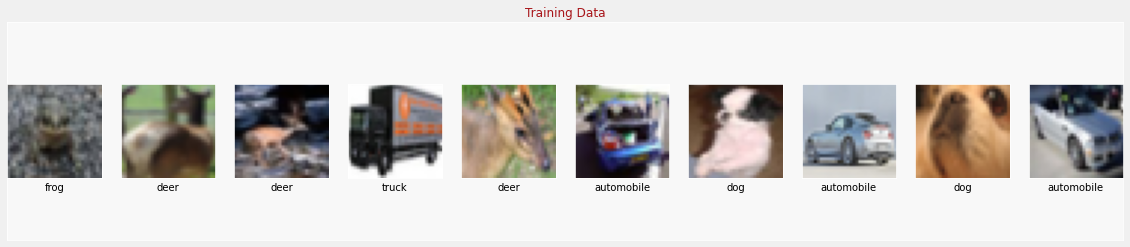

In [8]:
display_images(training_images, training_labels, training_labels, "Training Data")

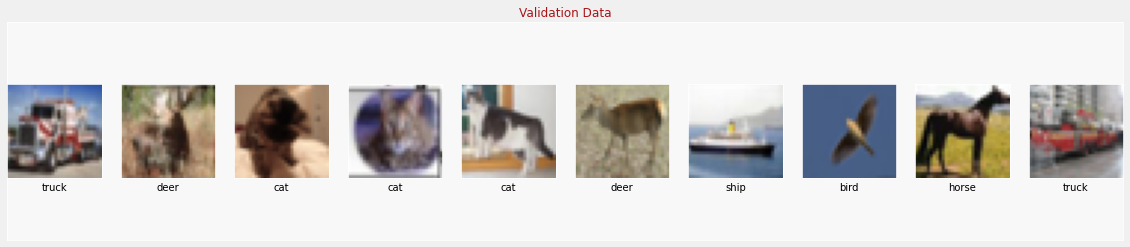

In [9]:
display_images(validation_images, validation_labels, validation_labels, "Validation Data")

In [10]:
validation_images[0].astype("float32").shape

(32, 32, 3)

In [11]:
def preprocess_image_input(input_images):
  input_images=input_images.astype("float32")
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images) 

  return output_ims


In [12]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [13]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

In [15]:
# this will take around 20 minutes to complete
EPOCHS = 1
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

782/782 [==============================] - 1082s 1s/step - loss: 0.3449 - accuracy: 0.8881 - val_loss: 0.2647 - val_accuracy: 0.9081


In [16]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 60s 380ms/step - loss: 0.2647 - accuracy: 0.9081


In [24]:
#plot_metrics("loss", "Loss")

In [25]:
#plot_metrics("accuracy", "Accuracy")

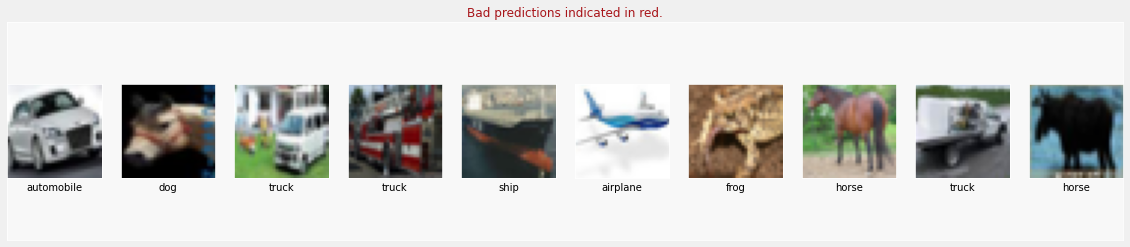

In [22]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis=1) 

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")